In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import numpy as np
import calendar
import sys,os
import sqlite3
from dateutil import parser

In [2]:
# connect to DB
SRC_DIR = os.path.dirname(os.getcwd())
dbname = "quickbooks.db"
dbpath = os.path.join(SRC_DIR,"db",dbname)
conn = sqlite3.connect(dbpath) 
alldf = pd.read_sql("select * from categorized_items", conn, parse_dates=['Date'])

In [3]:
alldf.to_csv('categorized_items.csv')

In [4]:
budget_file = os.path.join(SRC_DIR,'config','qb_to_budget_map.csv')
budgetdf = pd.read_csv(budget_file)

In [5]:
# Date information
year = 2024
month = 3 # month number (i.e. 4 for April)
days = calendar.monthrange(year,month)[1]
month_name = calendar.month_name[month]

In [6]:
print(f"Grabbing report details for {month_name}")
interval = (f"{year}-{month}-01",f"{year}-{month}-{days}")
interval_dates = (parser.parse(interval[0]),parser.parse(interval[1]))
qbdf = alldf.loc[(alldf['Date']>=interval_dates[0]) & (alldf['Date']<interval_dates[1])]

Grabbing report details for March


In [7]:
# data manipulation
budgetdf['Budget'] = budgetdf['Budget']
budget_items = budgetdf['QB_Item'].unique()

expenses = qbdf.loc[qbdf['Account_Type']=='Expenses']
income = qbdf.loc[qbdf['Account_Type'] == 'Income']

# check for unrecognized types and categories
types = qbdf["Transaction Type"].unique()
expected_types = ['Check','Expense','Deposit']
for t in types:
    if t not in expected_types:
        print(f"Warning: {t} not a recognized type")

for item in expenses['item'].unique():
    if item not in budget_items:
        print(f"Warning: {item} not in any budget category")

In [8]:
item_totals = expenses.groupby('item').aggregate({"Amount":"sum","Date":'count'}).reset_index()
item_totals.columns = ['item','Amount','Transactions']
all_totals = pd.merge(budgetdf,item_totals, left_on='QB_Item', right_on="item", how = 'left')
subcategory_totals = all_totals.groupby("Subcategory").aggregate({"Budget":"sum","Amount":"sum"}).reset_index()

In [9]:
total_expense = expenses['Amount'].sum()
total_income = income['Amount'].sum()
net_profit = total_income - total_expense

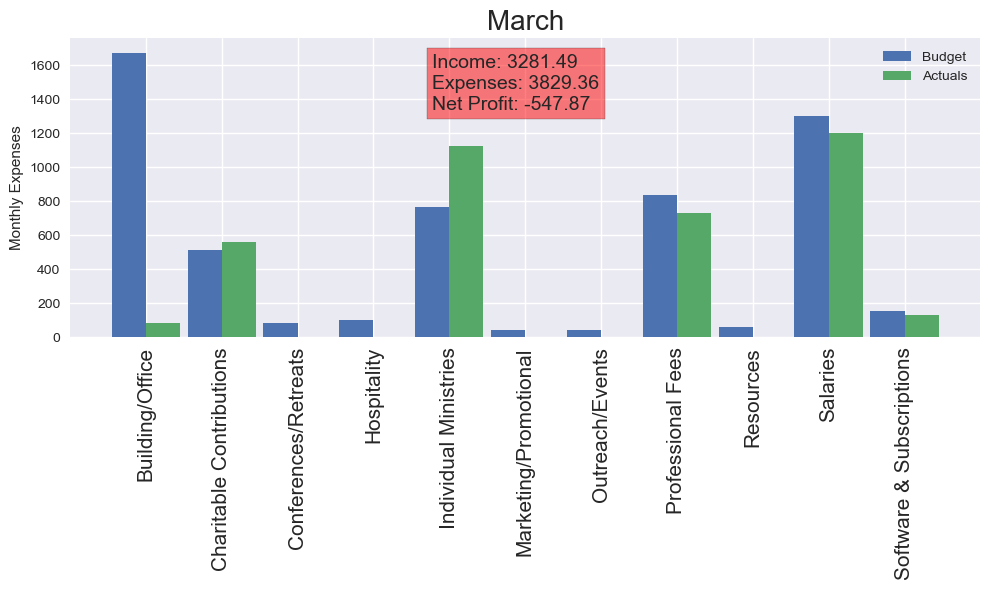

In [10]:
fig, ax = plt.subplots(figsize = (10,6))
ind = np.arange(len(subcategory_totals))
width = 0.45
budget = ax.bar(ind, subcategory_totals['Budget'], width, label = "Budget")
actual = ax.bar(ind+width, subcategory_totals["Amount"], width, label="Actuals")
ax.set_ylabel("Monthly Expenses")
ax.set_title(month_name, fontsize=20)
midx = ind.mean()
midy = max([subcategory_totals['Budget'].max(), subcategory_totals["Amount"].max()])*0.8
color = 'green'
if net_profit>0:
    color = 'green'
else:
    color = 'red'
ax.text(midx-1, midy, 'Income: {:.2f}\nExpenses: {:.2f}\nNet Profit: {:.2f}'.format(total_income,total_expense, net_profit), fontsize=14, bbox=dict(facecolor=color, alpha=0.5))
ax.legend()

ax.set_xticks(ind+width/2, subcategory_totals['Subcategory'], rotation=90, fontsize=15)
plt.tight_layout()
plt.savefig(f'{month_name}.png')

In [46]:
report_totals = all_totals[~all_totals['item'].isin(['Lead Pastor'])].sort_values(['Amount'], ascending=False).head(10)[['Item', 'Budget', 'Amount', 'Transactions']]
report_totals = report_totals.replace(np.NAN,0)
report_totals['Transactions'] = report_totals['Transactions'].astype(int)

In [47]:
report_totals

,Item,Budget,Amount,Transactions
24,Worship,83.00,1142.86,20
16,Lawn/Snow Service,125.00,400.00,1
13,Utilities,462.50,309.69,1
36,Life Network,129.00,186.00,1
37,Joel Frees,129.00,186.00,1
38,Crossfire,129.00,186.00,1
21,Software & Subscriptions,156.00,113.53,5
5,Communications,81.25,81.23,1
14,City Watershed Fees,21.07,24.05,1
1,Associate Pastor,0.00,0.00,0


In [143]:
all_totals.sort_values("Amount", ascending=False)

,Category,Subcategory,Item,QB_Item,Budget,item,Amount,Transactions
0,Salaries,Salaries,Lead Pastor,Lead Pastor,1300.00,Lead Pastor,1500.00,5.0
13,Facilities,Professional Fees,Utilities,Utilities,462.50,Utilities,629.17,1.0
16,Facilities,Professional Fees,Lawn/Snow Service,Lawn/Snow,125.00,Lawn/Snow,396.28,5.0
36,Giving,Charitable Contributions,Life Network,Life Network,129.00,Life Network,377.00,1.0
37,Giving,Charitable Contributions,Joel Frees,Joel Frees,129.00,Joel Frees,377.00,1.0
38,Giving,Charitable Contributions,Crossfire,Crossfire,129.00,Crossfire,377.00,1.0
15,Facilities,Professional Fees,Cleaning Service,Cleaning Service,217.00,Cleaning Service,300.00,1.0
5,Facilities,Building/Office,Communications,Communications,81.25,Communications,162.46,2.0
4,Facilities,Building/Office,Equipment,Equipment,42.00,Equipment,162.29,1.0
24,Ministry,Individual Ministries,Worship,Worship Expenses,83.00,Worship Expenses,116.58,3.0


In [23]:
special_account = qbdf[qbdf['item']=='Worship Contribution']

In [144]:
qbdf.loc[qbdf['Cate']]

,Date,Transaction Type,Num,Name,Memo/Description,Split,Amount,Balance,category,category_level,item,Account_Type
290,2023-07-31,Deposit,,,"Deposit Dividend 0.050% APY Earn Dividend, Dep...",ENT Savings (Keystone),0.20,.20,Income:Interest Earned,2,Interest Earned,Income
291,2023-07-19,Deposit,,,"Deposit Bulk Checks 1,51 Deposit, Proc...",1002 ENT Checking (Keystone),1000.00,1000.00,Income:Olive Tree (Tenant Lease),2,Olive Tree (Tenant Lease),Income
292,2023-07-02,Deposit,,,Deposit Home Banking Transfer RE InternetBanki...,1002 ENT Checking (Keystone),550.00,550.00,Income:Tithe:General Tithe,3,General Tithe,Income
293,2023-07-06,Deposit,,,"Tithe.ly : Tithe.ly : 1800948 ACH, Deposit,...",1002 ENT Checking (Keystone),404.10,954.10,Income:Tithe:General Tithe,3,General Tithe,Income
294,2023-07-11,Deposit,,,"Tithe.ly : Tithe.ly : 1800948 ACH, Deposit,...",1002 ENT Checking (Keystone),48.25,1002.35,Income:Tithe:General Tithe,3,General Tithe,Income
295,2023-07-12,Deposit,,,"Tithe.ly : Tithe.ly : 1800948 ACH, Deposit,...",1002 ENT Checking (Keystone),247.20,1249.55,Income:Tithe:General Tithe,3,General Tithe,Income
296,2023-07-16,Deposit,,Larry Metzler,Deposit Home Banking Transfer RE InternetBanki...,1002 ENT Checking (Keystone),205.00,1454.55,Income:Tithe:General Tithe,3,General Tithe,Income
297,2023-07-19,Deposit,,,"Deposit Bulk Checks 1,51 Deposit, Proc...",1002 ENT Checking (Keystone),528.06,1982.61,Income:Tithe:General Tithe,3,General Tithe,Income
298,2023-07-19,Deposit,,,"Tithe.ly : Tithe.ly : 1800948 ACH, Deposit,...",1002 ENT Checking (Keystone),648.00,2630.61,Income:Tithe:General Tithe,3,General Tithe,Income
299,2023-07-24,Deposit,,,"Tithe.ly : Tithe.ly : 1800948 ACH, Deposit,...",1002 ENT Checking (Keystone),150.00,2780.61,Income:Tithe:General Tithe,3,General Tithe,Income


In [43]:
special_account[['Date'],]

,Date,Transaction Type,Num,Name,Memo/Description,Split,Amount,Balance,category,category_level,item
13,2023-07-05,Deposit,,,Charitable contribution,1002 ENT Checking (Keystone),5000.00,5000.00,Income:Tithe:Worship Contribution,3,Worship Contribution
14,2023-07-06,Expense,,Amazon,New sound snake - Amazon,1002 ENT Checking (Keystone),-1297.32,3702.68,Income:Tithe:Worship Contribution,3,Worship Contribution


In [45]:
income['item'].unique()

array(['Interest Earned', 'Olive Tree (Tenant Lease)', 'General Tithe',
       'Worship Contribution'], dtype=object)